In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from math import ceil
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import squarify
import matplotlib

In [2]:
departments = pd.read_csv('departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [3]:
# Import order product dataset
order_prod = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])
order_prod.head()

,order_id,product_id
0,10,24
1,10,83
2,10,16
3,10,24
4,10,83


In [4]:
print('Total amount of unique order ids are:',len(order_prod['order_id'].unique()))

Total amount of unique order ids are: 200000


In [5]:
# Import order product dataset
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2425083,49125,1,2,18,NaN
1,1944304,162867,1,3,17,NaN
2,1201011,147243,14,0,16,3.0
3,1906860,195275,81,1,11,3.0
4,2766469,58222,3,6,11,6.0


In [6]:
# Import product label mapping
products = pd.read_csv('products.csv')
products.head()

,product_id,department_id,product_name
0,61,19,cookies cakes
1,104,13,spices seasonings
2,94,7,tea
3,38,1,frozen meals
4,5,13,marinades meat preparation


In [7]:
# Merge product labels
df = pd.merge(order_prod, products, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)
df.head()

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables


In [8]:
# Get modes and unique values
df.astype(object).describe()

,order_id,product_name
count,2019501,2019501
unique,200000,134
top,790903,fresh fruits
freq,137,226039


In [9]:
# Check product frequencies
df['product_name'].value_counts()

fresh fruits                  226039
fresh vegetables              212611
packaged vegetables fruits    109596
yogurt                         90751
packaged cheese                61502
                               ...  
kitchen supplies                 561
baby bath body care              515
baby accessories                 504
beauty                           387
frozen juice                     279
Name: product_name, Length: 134, dtype: int64

In [10]:
df['product_name'].value_counts(normalize=True)

fresh fruits                  0.111928
fresh vegetables              0.105279
packaged vegetables fruits    0.054269
yogurt                        0.044937
packaged cheese               0.030454
                                ...   
kitchen supplies              0.000278
baby bath body care           0.000255
baby accessories              0.000250
beauty                        0.000192
frozen juice                  0.000138
Name: product_name, Length: 134, dtype: float64

In [11]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Beginning of MBA

### Support

In [12]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% or 2.5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.025, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.043330,(asian foods)
1,0.045355,(baby food formula)
2,0.076635,(baking ingredients)
3,0.163865,(bread)
4,0.067765,(breakfast bakery)


### Confidence

In [13]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
463,"(fresh fruits, fresh herbs, packaged vegetable...",(fresh vegetables),0.043490,0.444360,0.039660,0.911934,2.052241,0.020335,6.309343
555,"(milk, yogurt, fresh vegetables, packaged vege...",(fresh fruits),0.036455,0.555995,0.032845,0.900974,1.620471,0.012576,4.483713
561,"(yogurt, fresh vegetables, packaged vegetables...",(fresh fruits),0.038635,0.555995,0.034565,0.894655,1.609106,0.013084,4.214775
339,"(fresh herbs, packaged vegetables fruits)",(fresh vegetables),0.052535,0.444360,0.046980,0.894261,2.012470,0.023636,5.254824
550,"(milk, fresh vegetables, packaged vegetables f...",(fresh fruits),0.032215,0.555995,0.028555,0.886388,1.594238,0.010644,3.908093


### Lift

In [14]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.3)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1974,"(fresh fruits, packaged vegetables fruits, pac...","(yogurt, fresh vegetables)",0.090715,0.144660,0.034565,0.381028,2.633959,0.021442,1.381873
1975,"(yogurt, fresh vegetables)","(fresh fruits, packaged vegetables fruits, pac...",0.144660,0.090715,0.034565,0.238940,2.633959,0.021442,1.194761
1945,"(yogurt, fresh vegetables)","(milk, fresh fruits, packaged vegetables fruits)",0.144660,0.087450,0.032845,0.227050,2.596337,0.020194,1.180606
1944,"(milk, fresh fruits, packaged vegetables fruits)","(yogurt, fresh vegetables)",0.087450,0.144660,0.032845,0.375586,2.596337,0.020194,1.369828
1980,"(yogurt, packaged vegetables fruits)","(fresh fruits, fresh vegetables, packaged cheese)",0.127910,0.104570,0.034565,0.270229,2.584193,0.021189,1.227001


#### Rules are of type `frozenset`, which is a Python built-in type that behaves similarly to sets except that it is immutable. Frozensets have functions to check if there are subsets, supersets, etc. More info at https://www.journaldev.com/22850/python-frozenset


### EXPLORE FREQUENT_ITEMSETS

In [15]:
# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Length=2 and Support>=0.2
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.2)]

,support,itemsets,length
180,0.317560,"(fresh vegetables, fresh fruits)",2
200,0.269870,"(fresh fruits, packaged vegetables fruits)",2
236,0.234555,"(fresh vegetables, packaged vegetables fruits)",2


In [16]:
# fresh fruits and yogurt
frequent_itemsets[ frequent_itemsets['itemsets'] == {'yogurt', 'fresh fruits'}]

,support,itemsets,length
214,0.188225,"(yogurt, fresh fruits)",2


In [17]:
# packaged cheese
frequent_itemsets[ frequent_itemsets['itemsets'] == {'packaged cheese'}]

,support,itemsets,length
46,0.230995,(packaged cheese),1


In [18]:
# High Confidence and high Lift - complementary products
rulesConfidence[(rulesConfidence['confidence'] >= 0.8) & (rulesConfidence['lift'] >= 1.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
463,"(fresh fruits, fresh herbs, packaged vegetable...",(fresh vegetables),0.043490,0.44436,0.039660,0.911934,2.052241,0.020335,6.309343
339,"(fresh herbs, packaged vegetables fruits)",(fresh vegetables),0.052535,0.44436,0.046980,0.894261,2.012470,0.023636,5.254824
228,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.44436,0.061815,0.881372,1.983463,0.030650,4.683872
341,"(yogurt, fresh herbs)",(fresh vegetables),0.029480,0.44436,0.025975,0.881106,1.982865,0.012875,4.673400
413,"(canned jarred vegetables, fresh fruits, packa...",(fresh vegetables),0.029740,0.44436,0.026065,0.876429,1.972340,0.012850,4.496526
337,"(fresh herbs, packaged cheese)",(fresh vegetables),0.030290,0.44436,0.026460,0.873556,1.965874,0.013000,4.394343
418,"(canned meals beans, fresh fruits, packaged ve...",(fresh vegetables),0.030560,0.44436,0.025905,0.847677,1.907635,0.012325,3.647768
72,(fresh herbs),(fresh vegetables),0.093005,0.44436,0.078655,0.845707,1.903203,0.037327,3.601205
138,"(canned jarred vegetables, packaged vegetables...",(fresh vegetables),0.037835,0.44436,0.031925,0.843795,1.898901,0.015113,3.557130
133,"(canned jarred vegetables, fresh fruits)",(fresh vegetables),0.048880,0.44436,0.040955,0.837868,1.885562,0.019235,3.427089


In [19]:
# High Confidence rules where "fresh vegetables" and "fresh fruits" are in the LHS
rulesConfidence[rulesConfidence['antecedents']=={'fresh vegetables', 'fresh fruits'}]  # Because rules are a "frozenset" object, the order of items is not important

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
258,"(fresh fruits, fresh vegetables)",(packaged vegetables fruits),0.31756,0.365415,0.18658,0.587543,1.607877,0.070539,1.538546


In [20]:
# High Confidence rules where "packaged vegetables fruits" is in the RHS
rulesConfidence[['packaged vegetables fruits' in elem for elem in rulesConfidence['consequents']]]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
560,"(fresh fruits, yogurt, fresh vegetables, packa...",(packaged vegetables fruits),0.049105,0.365415,0.034565,0.703900,1.926302,0.016621,2.143143
456,"(fresh fruits, fresh dips tapenades, fresh veg...",(packaged vegetables fruits),0.046625,0.365415,0.032265,0.692011,1.893767,0.015228,2.060413
549,"(fresh fruits, milk, fresh vegetables, package...",(packaged vegetables fruits),0.041475,0.365415,0.028555,0.688487,1.884124,0.013399,2.037106
547,"(yogurt, fresh vegetables, packaged cheese)",(packaged vegetables fruits),0.057195,0.365415,0.038635,0.675496,1.848572,0.017735,1.955554
554,"(fresh fruits, milk, yogurt, fresh vegetables)",(packaged vegetables fruits),0.048835,0.365415,0.032845,0.672571,1.840567,0.015000,1.938084
...,...,...,...,...,...,...,...,...,...
464,"(fresh vegetables, fresh herbs)","(fresh fruits, packaged vegetables fruits)",0.078655,0.269870,0.039660,0.504227,1.868408,0.018433,1.472711
31,(eggs),(packaged vegetables fruits),0.136490,0.365415,0.068650,0.502967,1.376427,0.018775,1.276747
494,"(fresh vegetables, packaged cheese)","(fresh fruits, packaged vegetables fruits)",0.135850,0.269870,0.068325,0.502944,1.863654,0.031663,1.468910
486,"(milk, fresh vegetables)","(fresh fruits, packaged vegetables fruits)",0.124715,0.269870,0.062535,0.501423,1.858018,0.028878,1.464428


In [21]:
# Substitue products
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.005)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
345,(soft drinks),(fresh vegetables),0.087310,0.444360,0.027845,0.318921,0.717709,-0.010952,0.815823
344,(fresh vegetables),(soft drinks),0.444360,0.087310,0.027845,0.062663,0.717709,-0.010952,0.973705
274,(fresh fruits),(soft drinks),0.555995,0.087310,0.039585,0.071197,0.815447,-0.008959,0.982652
275,(soft drinks),(fresh fruits),0.087310,0.555995,0.039585,0.453384,0.815447,-0.008959,0.812280
264,(paper goods),(fresh fruits),0.063575,0.555995,0.032090,0.504758,0.907847,-0.003257,0.896542
265,(fresh fruits),(paper goods),0.555995,0.063575,0.032090,0.057716,0.907847,-0.003257,0.993782
67,(fresh vegetables),(candy chocolate),0.444360,0.069305,0.028210,0.063485,0.916017,-0.002586,0.993785
66,(candy chocolate),(fresh vegetables),0.069305,0.444360,0.028210,0.407041,0.916017,-0.002586,0.937064
336,(paper goods),(fresh vegetables),0.063575,0.444360,0.025885,0.407157,0.916277,-0.002365,0.937246
337,(fresh vegetables),(paper goods),0.444360,0.063575,0.025885,0.058252,0.916277,-0.002365,0.994348


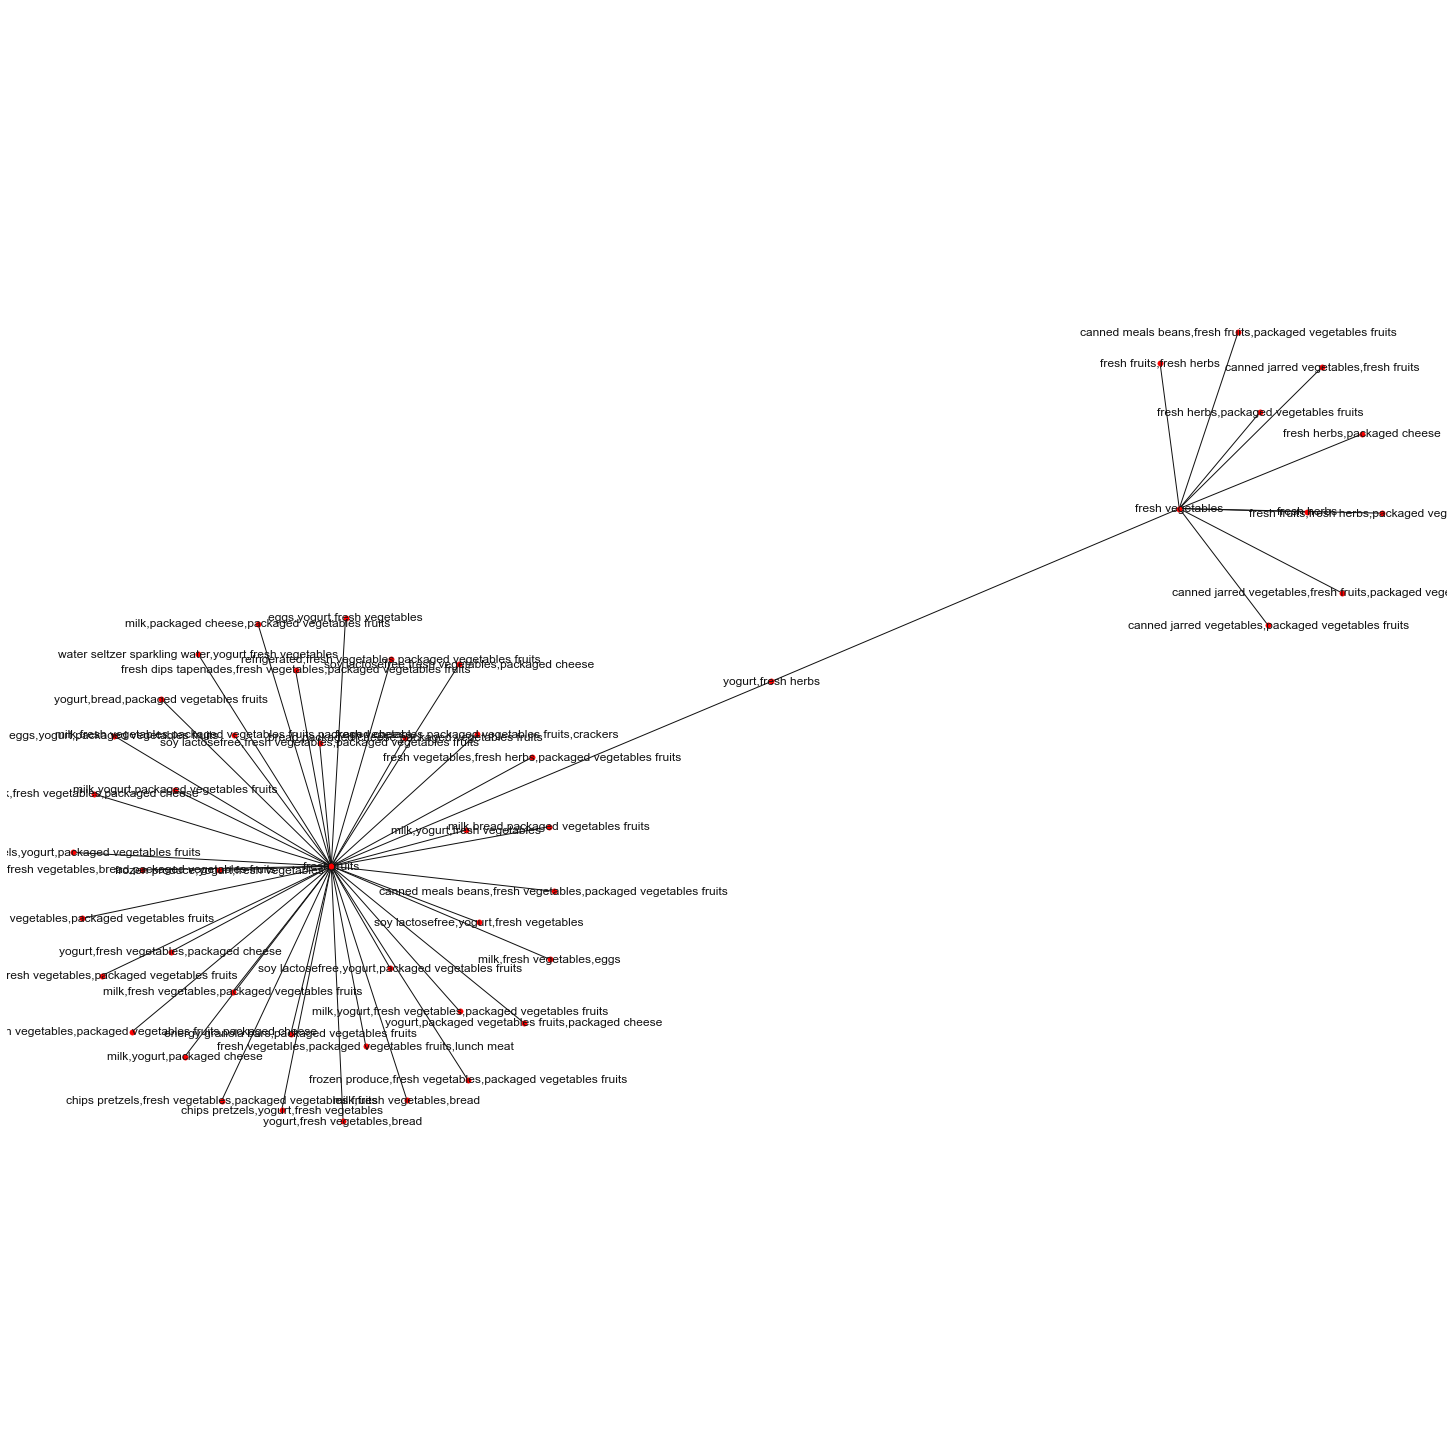

In [22]:
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')
# TRY TO PLOT THE DIRECTION OF SOURCE -> TARGET

# 1. Analysis Objectives
<img src="img/lel.jpg" alt="ehm" width="600"/>

### Objectives
**You should aim to provide an overview of Instacart's business as
complete as possible. Jane is particularly interested in the topics
below:**

* What are the main types of consumer behavior in the business? <br>
* Which types of products should have an extended amount of product offerings? <br>
* Which types of products can be seen as substitutes? <br>
* Which items are complementary? <br>

## Important:
#### In the following and rest of this notebook, the focus will be mainly on Market Basket Analysis and especially finding the complementary and substitues with different thresholds

# 2. Checking for substitues

### Which types of products can be seen as substitutes?
If the lift is < 1, that lets us know the items are substitute to each other. This means that presence of one item has negative effect on presence of other item and vice versa. Below, the formula for calculating the Lift:

$$Lift \: (x→y) = \frac{supp\:(x,y)}{supp\:(x)\: * supp\:(y)}$$

## 2.1. Support at 5% (Experimenting)

In [23]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions
frequent_itemsets_five = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets_five.head()

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)


In [24]:
# Generate the association rules - by lift with min threshold of 0.01
ruleLift = association_rules(frequent_itemsets_five, metric="lift", min_threshold=0.01)
ruleLift.sort_values(by='lift', ascending=True, inplace=True)
ruleLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
110,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
111,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
232,"(fresh fruits, fresh vegetables)",(water seltzer sparkling water),0.317560,0.193005,0.063235,0.199128,1.031723,0.001944,1.007645
233,(water seltzer sparkling water),"(fresh fruits, fresh vegetables)",0.193005,0.317560,0.063235,0.327634,1.031723,0.001944,1.014983
82,(water seltzer sparkling water),(fresh fruits),0.193005,0.555995,0.111045,0.575348,1.034807,0.003735,1.045573


In [25]:
print('Amount of substitues found:',len(ruleLift[(ruleLift['lift'] < 1)]))

Amount of substitues found: 2


In [26]:
ruleSubs = ruleLift[(ruleLift['lift'] < 1)]
ruleSubs

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
110,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
111,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328


In [27]:
ruleSubs['length_ant'] = ruleSubs['antecedents'].apply(lambda x: len(x))
ruleSubs['length_cons'] = ruleSubs['consequents'].apply(lambda x: len(x))

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 2.2. Support at 2.5% (Chosen)

In [28]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 2.5% of the transactions
frequent_itemsets_twofive = apriori(pt, min_support=0.025, use_colnames=True)
frequent_itemsets_twofive.head()

,support,itemsets
0,0.043330,(asian foods)
1,0.045355,(baby food formula)
2,0.076635,(baking ingredients)
3,0.163865,(bread)
4,0.067765,(breakfast bakery)


In [29]:
# Generate the association rules - by lift with min threshold of 0.01
ruleLift = association_rules(frequent_itemsets_twofive, metric="lift", min_threshold=0.01)
ruleLift.sort_values(by='lift', ascending=True, inplace=True)
ruleLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
345,(soft drinks),(fresh vegetables),0.087310,0.444360,0.027845,0.318921,0.717709,-0.010952,0.815823
344,(fresh vegetables),(soft drinks),0.444360,0.087310,0.027845,0.062663,0.717709,-0.010952,0.973705
274,(fresh fruits),(soft drinks),0.555995,0.087310,0.039585,0.071197,0.815447,-0.008959,0.982652
275,(soft drinks),(fresh fruits),0.087310,0.555995,0.039585,0.453384,0.815447,-0.008959,0.812280
264,(paper goods),(fresh fruits),0.063575,0.555995,0.032090,0.504758,0.907847,-0.003257,0.896542


## 2.3. Scatter plot - Confidence vs Support

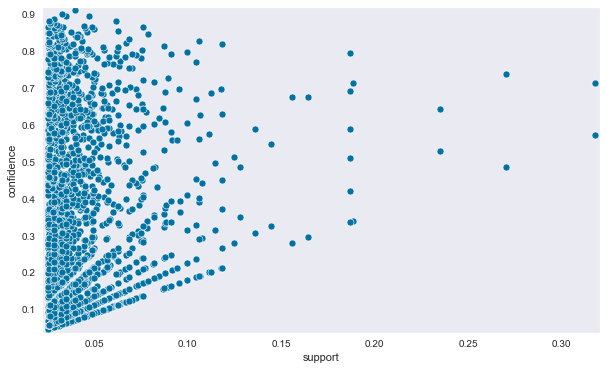

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", data = ruleLift)
plt.margins(0.01,0.01)
plt.savefig('scatter_conf_support.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

In [31]:
print('Amount of substitues found:',len(ruleLift[(ruleLift['lift'] < 1) & (ruleLift['confidence'] > 0.1)]))

Amount of substitues found: 9


## 2.4 Table - Substitute itemsets

In [32]:
ruleSubs = ruleLift[(ruleLift['lift'] < 1) & (ruleLift['confidence'] > 0.15)]
ruleSubs.reset_index(drop=True, inplace=True)
ruleSubs

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(soft drinks),(fresh vegetables),0.087310,0.444360,0.027845,0.318921,0.717709,-0.010952,0.815823
1,(soft drinks),(fresh fruits),0.087310,0.555995,0.039585,0.453384,0.815447,-0.008959,0.812280
2,(paper goods),(fresh fruits),0.063575,0.555995,0.032090,0.504758,0.907847,-0.003257,0.896542
3,(candy chocolate),(fresh vegetables),0.069305,0.444360,0.028210,0.407041,0.916017,-0.002586,0.937064
4,(paper goods),(fresh vegetables),0.063575,0.444360,0.025885,0.407157,0.916277,-0.002365,0.937246
5,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
6,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
7,(milk),(water seltzer sparkling water),0.243325,0.193005,0.046610,0.191555,0.992485,-0.000353,0.998206
8,(water seltzer sparkling water),(milk),0.193005,0.243325,0.046610,0.241496,0.992485,-0.000353,0.997589


In [33]:
ruleSubs['length_ant'] = ruleSubs['antecedents'].apply(lambda x: len(x))
ruleSubs['length_cons'] = ruleSubs['consequents'].apply(lambda x: len(x))

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 2.4. Heatmap - Substitute itemsets

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


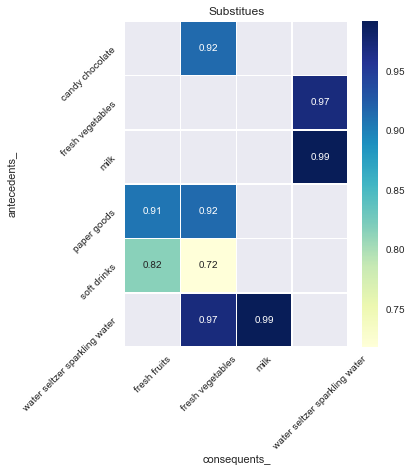

In [34]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
ruleSubs['antecedents_'] = ruleSubs['antecedents'].apply(lambda a: ','.join(list(a)))
ruleSubs['consequents_'] = ruleSubs['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = ruleSubs[ruleSubs['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(5,6)) 
sns.heatmap(pivot, annot = True, linewidths=.5,ax=ax, cmap="YlGnBu").set_title("Substitues")
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.savefig('all_subs_heatmap.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

# 3. Checking for complementaries
### Which types of products can be seen as complementaries?

If the lift is > 1, that lets us know the degree to which those two occurrences are dependent on one another, and makes those rules potentially useful for predicting the consequent in future data sets.

## 3.1. Support at 5%

In [35]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions
frequent_itemsets_five = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets_five.head()

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)


In [36]:
# Generate the association rules - by lift with min threshold of 0.01
ruleLift = association_rules(frequent_itemsets_five, metric="lift", min_threshold=0.01)
ruleLift.sort_values(by='lift', ascending=False, inplace=True)
ruleLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
193,(fresh herbs),"(fresh fruits, fresh vegetables)",0.093005,0.317560,0.061815,0.664642,2.092964,0.032280,2.034958
188,"(fresh fruits, fresh vegetables)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221
191,(fresh vegetables),"(fresh fruits, fresh herbs)",0.444360,0.070135,0.061815,0.139110,1.983463,0.030650,1.080121
190,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
381,"(fresh fruits, packaged vegetables fruits)","(yogurt, fresh vegetables)",0.269870,0.144660,0.076240,0.282506,1.952899,0.037201,1.192122


In [37]:
print('Amount of substitues found:',len(ruleLift[(ruleLift['lift'] > 1)]))

Amount of substitues found: 384


In [38]:
ruleCom = ruleLift[(ruleLift['lift'] > 1)]
ruleCom.reset_index(drop=True, inplace=True)
ruleCom

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh herbs),"(fresh fruits, fresh vegetables)",0.093005,0.317560,0.061815,0.664642,2.092964,0.032280,2.034958
1,"(fresh fruits, fresh vegetables)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221
2,(fresh vegetables),"(fresh fruits, fresh herbs)",0.444360,0.070135,0.061815,0.139110,1.983463,0.030650,1.080121
3,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
4,"(fresh fruits, packaged vegetables fruits)","(yogurt, fresh vegetables)",0.269870,0.144660,0.076240,0.282506,1.952899,0.037201,1.192122
...,...,...,...,...,...,...,...,...,...
379,(packaged vegetables fruits),(water seltzer sparkling water),0.365415,0.193005,0.073715,0.201730,1.045204,0.003188,1.010929
380,(water seltzer sparkling water),(fresh fruits),0.193005,0.555995,0.111045,0.575348,1.034807,0.003735,1.045573
381,(fresh fruits),(water seltzer sparkling water),0.555995,0.193005,0.111045,0.199723,1.034807,0.003735,1.008395
382,(water seltzer sparkling water),"(fresh fruits, fresh vegetables)",0.193005,0.317560,0.063235,0.327634,1.031723,0.001944,1.014983


In [39]:
ruleCom['length_ant'] = ruleCom['antecedents'].apply(lambda x: len(x))
ruleCom['length_cons'] = ruleCom['consequents'].apply(lambda x: len(x))

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
rule_Com_new = ruleCom[(ruleCom['lift'] > 1) &
        (ruleCom['confidence'] > 0.15) &
        (ruleCom['length_ant'] <= 2) &
        (ruleCom['length_cons'] == 1)]
rule_Com_new.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_ant,length_cons
1,"(fresh fruits, fresh vegetables)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221,2,1
3,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872,2,1
6,(fresh vegetables),(fresh herbs),0.444360,0.093005,0.078655,0.177007,1.903203,0.037327,1.102069,1,1
7,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205,1,1
21,"(milk, packaged vegetables fruits)",(yogurt),0.107425,0.263675,0.051295,0.477496,1.810926,0.022970,1.409223,2,1
26,"(yogurt, packaged vegetables fruits)",(packaged cheese),0.127910,0.230995,0.051915,0.405871,1.757057,0.022368,1.294341,2,1
28,"(milk, fresh fruits)",(yogurt),0.164310,0.263675,0.074860,0.455602,1.727893,0.031536,1.352550,2,1
32,(canned jarred vegetables),(fresh vegetables),0.071890,0.444360,0.055055,0.765823,1.723429,0.023110,2.372733,1,1
34,"(milk, fresh vegetables)",(yogurt),0.124715,0.263675,0.056510,0.453113,1.718453,0.023626,1.346394,2,1
39,"(packaged cheese, packaged vegetables fruits)",(yogurt),0.114610,0.263675,0.051915,0.452971,1.717914,0.021695,1.346044,2,1


In [41]:
print('Amount of complementaries found:',len(rule_Com_new))

Amount of complementaries found: 213


## 3.2. Support at 2.5%

In [42]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 2.5% of the transactions
frequent_itemsets_twofive = apriori(pt, min_support=0.025, use_colnames=True)
frequent_itemsets_twofive.head()

,support,itemsets
0,0.043330,(asian foods)
1,0.045355,(baby food formula)
2,0.076635,(baking ingredients)
3,0.163865,(bread)
4,0.067765,(breakfast bakery)


In [43]:
# Generate the association rules - by lift with min threshold of 0.01
ruleLift_five = association_rules(frequent_itemsets_twofive, metric="lift", min_threshold=0.01)
ruleLift_five.sort_values(by='lift', ascending=False, inplace=True)
ruleLift_five.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2358,"(fresh fruits, packaged vegetables fruits, pac...","(yogurt, fresh vegetables)",0.090715,0.144660,0.034565,0.381028,2.633959,0.021442,1.381873
2359,"(yogurt, fresh vegetables)","(fresh fruits, packaged vegetables fruits, pac...",0.144660,0.090715,0.034565,0.238940,2.633959,0.021442,1.194761
2329,"(yogurt, fresh vegetables)","(milk, fresh fruits, packaged vegetables fruits)",0.144660,0.087450,0.032845,0.227050,2.596337,0.020194,1.180606
2328,"(milk, fresh fruits, packaged vegetables fruits)","(yogurt, fresh vegetables)",0.087450,0.144660,0.032845,0.375586,2.596337,0.020194,1.369828
2364,"(yogurt, packaged vegetables fruits)","(fresh fruits, fresh vegetables, packaged cheese)",0.127910,0.104570,0.034565,0.270229,2.584193,0.021189,1.227001


In [44]:
print('Amount of substitues found:',len(ruleLift[(ruleLift['lift'] > 1)]))

Amount of substitues found: 384


## Insight:
### Too many rules found when decreasing the support threshold from 5% to 2.5%. <br> As a results, the analysis of the complementary itemsets will be continued with minimum support threshold of 5%.

## 3.3. Analysing Complementary Itemsets

In [45]:
rule_Com_new.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_ant,length_cons
1,"(fresh fruits, fresh vegetables)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221,2,1
3,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872,2,1
6,(fresh vegetables),(fresh herbs),0.444360,0.093005,0.078655,0.177007,1.903203,0.037327,1.102069,1,1
7,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205,1,1
21,"(milk, packaged vegetables fruits)",(yogurt),0.107425,0.263675,0.051295,0.477496,1.810926,0.022970,1.409223,2,1


In [46]:
if len(rule_Com_new) == len(rule_Com_new[rule_Com_new['support'] >= 0.05]):
    print('Correct dataframe')

Correct dataframe


## 3.4. Table - Complementary Itemsets (2:1)

In [47]:
ruleCom_2_1 = rule_Com_new[(rule_Com_new['length_ant'] == 2) & (rule_Com_new['length_cons'] == 1)]
print("Two to one relationship rules found:", len(ruleCom_2_1))
ruleCom_2_1.reset_index(drop=True,inplace=True)
ruleCom_2_1[:20].loc[:,:'conviction']

Two to one relationship rules found: 102


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(fresh fruits, fresh vegetables)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221
1,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
2,"(milk, packaged vegetables fruits)",(yogurt),0.107425,0.263675,0.051295,0.477496,1.810926,0.022970,1.409223
3,"(yogurt, packaged vegetables fruits)",(packaged cheese),0.127910,0.230995,0.051915,0.405871,1.757057,0.022368,1.294341
4,"(milk, fresh fruits)",(yogurt),0.164310,0.263675,0.074860,0.455602,1.727893,0.031536,1.352550
5,"(milk, fresh vegetables)",(yogurt),0.124715,0.263675,0.056510,0.453113,1.718453,0.023626,1.346394
6,"(packaged cheese, packaged vegetables fruits)",(yogurt),0.114610,0.263675,0.051915,0.452971,1.717914,0.021695,1.346044
7,"(yogurt, fresh vegetables)",(packaged cheese),0.144660,0.230995,0.057195,0.395375,1.711619,0.023779,1.271872
8,"(fresh fruits, packaged cheese)",(yogurt),0.155900,0.263675,0.070020,0.449134,1.703362,0.028913,1.336668
9,"(soy lactosefree, fresh vegetables)",(packaged vegetables fruits),0.094120,0.365415,0.057695,0.612994,1.677528,0.023302,1.639729


## 3.5. Heatmap - Complementary Itemsets (2:1)

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


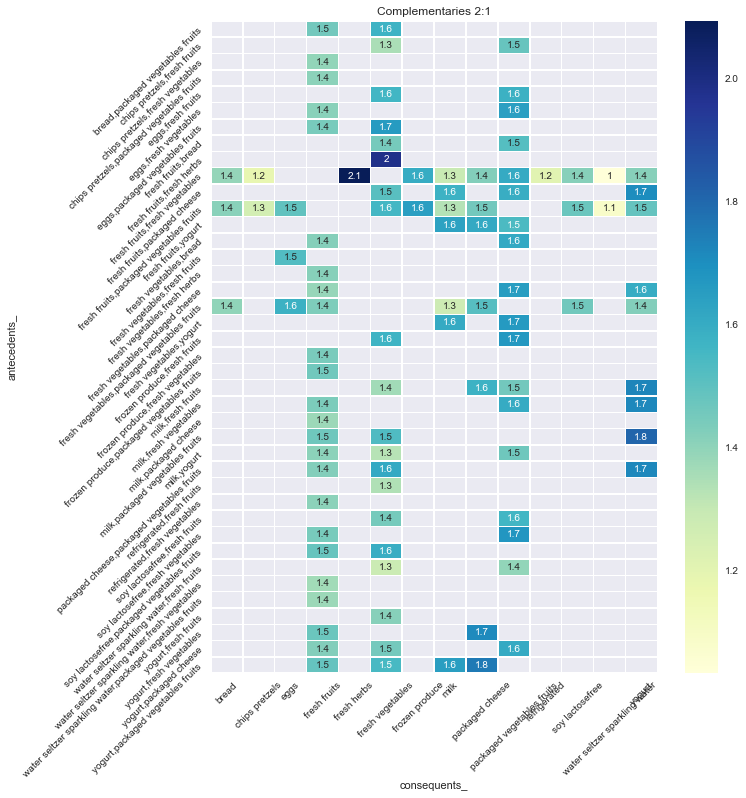

In [48]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
ruleCom_2_1['antecedents_'] = ruleCom_2_1['antecedents'].apply(lambda a: ','.join(list(a)))
ruleCom_2_1['consequents_'] = ruleCom_2_1['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = ruleCom_2_1[ruleCom_2_1['length_ant']==2].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,12)) 
sns.heatmap(pivot, annot = True, linewidths=.5,ax=ax, cmap="YlGnBu").set_title("Complementaries 2:1")
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.savefig('all_coms_heatmap.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

## 3.6. Table - Complementary Itemsets (1:1)

In [49]:
ruleCom_1_1 = rule_Com_new[(rule_Com_new['length_ant'] == 1) & (rule_Com_new['length_cons'] == 1)]
print("One to one relationship rules found:", len(ruleCom_1_1))
ruleCom_1_1.reset_index(drop=True,inplace=True)
ruleCom_1_1[:20].loc[:,:'conviction']

One to one relationship rules found: 111


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh vegetables),(fresh herbs),0.444360,0.093005,0.078655,0.177007,1.903203,0.037327,1.102069
1,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
2,(canned jarred vegetables),(fresh vegetables),0.071890,0.444360,0.055055,0.765823,1.723429,0.023110,2.372733
3,(canned meals beans),(fresh vegetables),0.069705,0.444360,0.050435,0.723549,1.628295,0.019461,2.009906
4,(bread),(packaged cheese),0.163865,0.230995,0.059690,0.364263,1.576931,0.021838,1.209628
5,(packaged cheese),(bread),0.230995,0.163865,0.059690,0.258404,1.576931,0.021838,1.127480
6,(fresh herbs),(packaged vegetables fruits),0.093005,0.365415,0.052535,0.564862,1.545810,0.018550,1.458354
7,(fresh dips tapenades),(packaged vegetables fruits),0.098205,0.365415,0.053785,0.547681,1.498791,0.017899,1.402959
8,(milk),(bread),0.243325,0.163865,0.059705,0.245371,1.497400,0.019833,1.108009
9,(bread),(milk),0.163865,0.243325,0.059705,0.364355,1.497400,0.019833,1.190405


## 3.7. Heatmap - Complementary Itemsets (1:1)

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


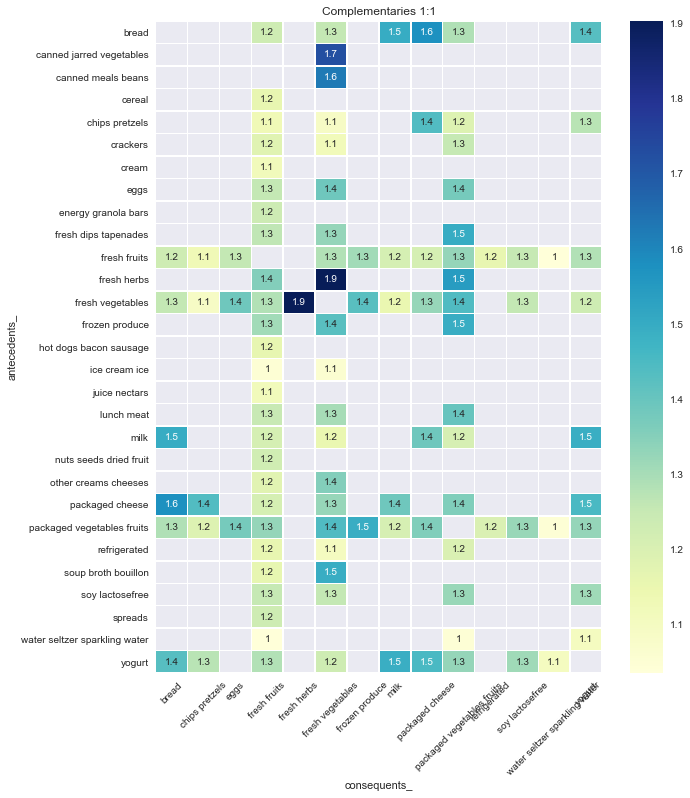

In [50]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
ruleCom_1_1['antecedents_'] = ruleCom_1_1['antecedents'].apply(lambda a: ','.join(list(a)))
ruleCom_1_1['consequents_'] = ruleCom_1_1['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = ruleCom_1_1[ruleCom_1_1['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,12)) 
sns.heatmap(pivot, annot = True,linewidths=.5,ax=ax, cmap="YlGnBu").set_title("Complementaries 1:1")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.savefig('all_coms_heatmap.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()

## 3.7. Table - Complementary Itemsets with Conviction Constraints

In [51]:
ruleComConv = ruleCom_1_1[ruleCom_1_1['conviction'] >= 1.3].reset_index(drop=True)
print('Rule found with the new striction:', len(ruleComConv))
ruleComConv.loc[:,:'conviction']

Rule found with the new striction: 31


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
1,(canned jarred vegetables),(fresh vegetables),0.071890,0.444360,0.055055,0.765823,1.723429,0.023110,2.372733
2,(canned meals beans),(fresh vegetables),0.069705,0.444360,0.050435,0.723549,1.628295,0.019461,2.009906
3,(fresh herbs),(packaged vegetables fruits),0.093005,0.365415,0.052535,0.564862,1.545810,0.018550,1.458354
4,(fresh dips tapenades),(packaged vegetables fruits),0.098205,0.365415,0.053785,0.547681,1.498791,0.017899,1.402959
5,(frozen produce),(packaged vegetables fruits),0.122580,0.365415,0.066985,0.546459,1.495449,0.022192,1.399180
6,(soup broth bouillon),(fresh vegetables),0.083365,0.444360,0.055380,0.664308,1.494976,0.018336,1.655206
7,(packaged vegetables fruits),(fresh vegetables),0.365415,0.444360,0.234555,0.641887,1.444519,0.072179,1.551576
8,(fresh vegetables),(packaged vegetables fruits),0.444360,0.365415,0.234555,0.527849,1.444519,0.072179,1.344030
9,(frozen produce),(fresh vegetables),0.122580,0.444360,0.077750,0.634280,1.427400,0.023280,1.519303


## 3.8. Heatmap - Complementary Itemsets with Conviction Constraints

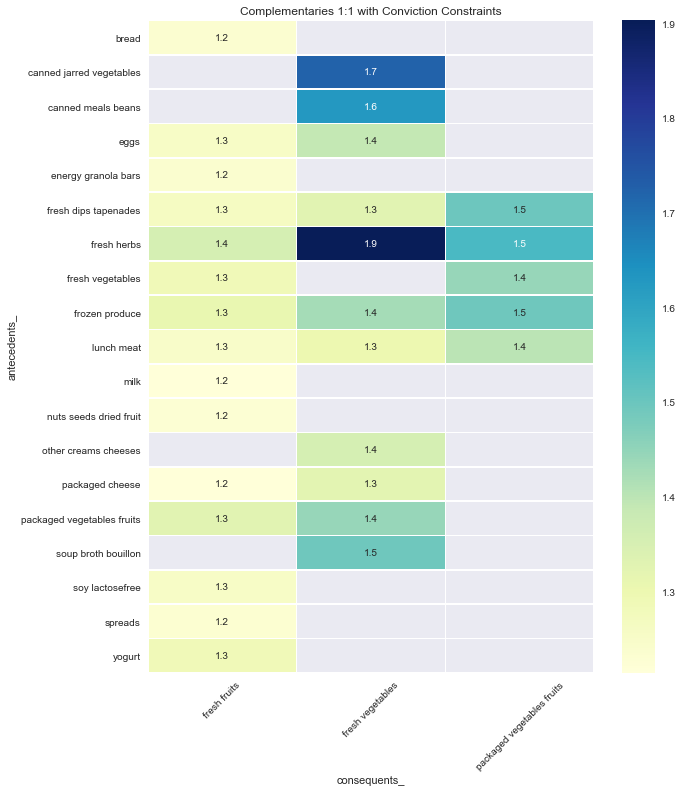

In [52]:
# Import seaborn under its standard alias
import seaborn as sns

# Replace frozen sets with strings
ruleComConv['antecedents_'] = ruleComConv['antecedents'].apply(lambda a: ','.join(list(a)))
ruleComConv['consequents_'] = ruleComConv['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = ruleComConv[ruleComConv['length_ant']==1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(10,12)) 
sns.heatmap(pivot, annot = True,linewidths=.5,ax=ax, cmap="YlGnBu").set_title("Complementaries 1:1 with Conviction Constraints")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.savefig('all_coms_conv_heatmap.png',bbox_inches='tight',dpi=250, transparent=True)
plt.show()